# Code to run GA with Linear ML model 
This notebook was made on Google Colab ([link to notebook](https://colab.research.google.com/drive/1j9gOa6u0RC98X6P3RA77vasgSLjZ7HFz?usp=sharing)). If you are running on your local machine remove the cells related to data retrieval and RDKit installation, and change the paths to the files as needed.


# Software installation and data retrieval, etc.

In [1]:
%%capture
# Install RDKit
# takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [2]:
! rm -rf linear_barrier27_model.pkl storage-14_model.csv storage-57_model.csv
! wget https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_models/linear_regression/linear_barrier27_model.pkl
! wget https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_models/linear_regression/storage-24_model.csv
! wget https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_models/linear_regression/storage-57_model.csv

--2020-07-03 11:12:56--  https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_models/linear_regression/linear_barrier27_model.pkl
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5100 (5.0K)
Saving to: ‘linear_barrier27_model.pkl’

linear_barrier27_mo 100%[===================>]   4.98K  --.-KB/s    in 0s      

2020-07-03 11:12:58 (149 MB/s) - ‘linear_barrier27_model.pkl’ saved [5100/5100]

--2020-07-03 11:12:59--  https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_models/linear_regression/storage-24_model.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5405 (5.3K) [text/csv]
Saving to: ‘storage-24_model.csv’

storage-24_model.cs 100%[===================>]   5.28K  --.-KB/s    in 0s      

20

In [3]:
import sys 
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import pickle
import random
from collections import OrderedDict
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sklearn
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load ML Models

In [4]:
barrier_model = pickle.load(open('/content/linear_barrier27_model.pkl', 'rb'))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
density_coefs57 = np.genfromtxt('/content/storage-57_model.csv')
density_coefs24 = np.genfromtxt('/content/storage-24_model.csv')

def density_model_14(gene):
    bias = density_coefs24[0]
    coefs = density_coefs24[1:]
    return gene.dot(coefs) + bias

def density_model_57(gene):
    bias = density_coefs57[0]
    coefs = density_coefs57[1:]
    return gene.dot(coefs) + bias

# Misc Functions

## One-Hot Representation
Makes one-hot encoding of genes.

In [6]:
def one_hot(gene):
    """Creates one-hot representation"""
    one_hot = np.zeros((7,41), dtype=np.float32)
    for i, base in enumerate([int(x) for x in gene.split('-')]):
        if base == 0:
            continue
        one_hot[i,base - 1] = 1.
    return one_hot

## GA helper functions

In [7]:
def make_initial_population(population_size): 
  initial_mating_pool = []
  for i in range(population_size):
    gene = []
    for j in range(7):
      gene.append(41*[0.])
    gene[random.randint(0,6)][random.randint(0,40)] = 1.
    initial_mating_pool.append(gene)
  return initial_mating_pool

population_test = make_initial_population(5)

In [8]:
def make_array(population):
  pop2 = []
  for gene in population:
    gene2 = [item for sublist in gene for item in sublist]
    pop2.append(gene2)
  pop2 = np.array(pop2)
  return pop2

def ThresholdedLinearModifier(scores, threshold):
    return np.minimum(scores, threshold) / threshold

def calculate_scores(population):
    pop2 = make_array(population)

    # Storage Density
    density_scores = np.zeros(pop2.shape[0])
    for i, gene in enumerate(pop2):
        if gene.sum(axis=0) <= 4:
            density_scores[i] = density_model_14(gene.reshape(1,287))
        else:
            density_scores[i] = density_model_57(gene.reshape(1,287))

    density_scores = ThresholdedLinearModifier(density_scores,1.)

    # Barrier
    barrier_scores = barrier_model.predict(pop2)
    barrier_scores = ThresholdedLinearModifier(barrier_scores, 180)
  
    return list(density_scores + barrier_scores)

In [9]:
def mutate(child, mutation_rate):
  mutated_child = child
  if np.random.random() < mutation_rate:
    x = random.randint(0,6)
    mutated_child[x] = 41*[0.]
    mutated_child[x][random.randint(0,40)] = 1.
    
  return mutated_child

In [10]:
def calculate_normalized_fitness(scores):  
  #calculate probability
  sum_scores = sum(scores)
  normalized_fitness = [score/sum_scores for score in scores]

  return normalized_fitness

In [11]:
def make_mating_pool(population,fitness,mating_pool_size):
  indices = range(len(population))
  mating_pool = []
  for i in range(mating_pool_size):
    index = np.random.choice(indices, p=fitness)
    mating_pool.append(population[index])

  return mating_pool

In [12]:
def crossover(parent_A,parent_B):
  cut = np.random.randint(1,len(parent_A)-1)
  child = parent_A[:cut] + parent_B[cut:]
  
  return child

In [13]:
def reproduce(mating_pool, population_size, mutation_rate):
  new_population = []
  for n in range(population_size):
    parent_A = random.choice(mating_pool)
    parent_B = random.choice(mating_pool)
    new_child = crossover(parent_A, parent_B)

    if new_child != None:
	    new_child = mutate(new_child,mutation_rate)
	    if new_child != None:
	    	new_population.append(new_child)
 
  return new_population

# Run GA

In [14]:
import time

population_size = 100 
mating_pool_size = 100
generations = 100
mutation_rate = 0.20

print('population_size', population_size)
print('mating_pool_size', mating_pool_size)
print('generations', generations)
print('mutation_rate', mutation_rate)
print('')

results = []
t0 = time.time()
for i in range(1000):
    population = make_initial_population(population_size)
    scores = calculate_scores(population)
    fitness = calculate_normalized_fitness(scores)

    for generation in range(generations):
        mating_pool = make_mating_pool(population, fitness, mating_pool_size)
        new_population = reproduce(mating_pool, population_size, mutation_rate)
        new_scores = calculate_scores(new_population)
      
        population_tuples = list(zip(scores+new_scores,population+new_population))

        # Sort Pupulation tuples
        population_tuples = sorted(population_tuples, key=lambda x: x[0], reverse=True)[:population_size]
        
        population = [t[1] for t in population_tuples]
        scores = [t[0] for t in population_tuples]  
        fitness = calculate_normalized_fitness(scores)

    # Calculate density + barrier
    flat_gene = np.array(population[0]).flatten()
    if flat_gene.sum() <= 4:
        density = density_model_14(flat_gene.reshape(1,287))
    else:
        density = density_model_57(flat_gene.reshape(1,287))
    
    barrier = barrier_model.predict(flat_gene.reshape(1,287))
    
    # Get Gene
    gene_str = "-".join([str(x+1) for x in np.array(population[0]).argmax(axis=1)])

    # print results from 
    print(f"iter: {i+1} - gene: {gene_str}, fitness: {scores[0]:.2f}, density: {density[0]:.2f}, barrier: {barrier[0]:.2f}")
    results.append((gene_str, max(scores), density[0], barrier[0]))

t1 = time.time()
print('')
print('time ',t1-t0)


population_size 100
mating_pool_size 100
generations 100
mutation_rate 0.2

iter: 1 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 2 - gene: 9-16-5-1-6-1-1, fitness: 1.47, density: 0.47, barrier: 182.31
iter: 3 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 4 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 5 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 6 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 7 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 8 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 9 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 10 - gene: 7-16-18-18-5-7-14, fitness: 1.53, density: 0.53, barrier: 190.37
iter: 11 - gene: 9-16-5-1-6-1-1, fitness: 1.47, density: 0.47, barrier: 182.31
iter: 12 - gene: 7-16-18-18-5-7-14, f

# Analyse GA results
Can we find the 'best' molecules? The best 5 molecules (density >= 180 kJ/mol) have the genes:

1. 7-16-18-18-5-7-14  (0.531, 190.37)
2. 7-16-18-14-5-7-14  (0.529, 183.13)
3. 7-16-18-0-5-7-14    (0.528, 183.99)    
4. 7-16-18-18-5-7-16  (0.526, 183.40)
5. 7-16-18-18-14-7-14 (0.525, 184.89)

In [15]:
df_ga = pd.DataFrame(results, columns=['gene', 'fitness', 'density', 'barrier'])
df_ga_unique = df_ga.drop_duplicates().set_index("gene")

# count gene occurrence
gene_count = df_ga.groupby('gene').count().sort_values("barrier", ascending=False)["barrier"]
gene_count.rename("num_found", inplace=True)

df_ga_unique = pd.concat([df_ga_unique, gene_count], axis=1)

In [16]:
# Add Stats
df_ga_unique["found_procentage"] = df_ga_unique["num_found"] / df_ga_unique["num_found"].sum()
df_ga_unique["95_certian"] = (np.log(-0.95 + 1) / np.log(1 - df_ga_unique["found_procentage"])).round(2)
df_ga_unique["99_certian"] = (np.log(-0.99 + 1) / np.log(1 - df_ga_unique["found_procentage"])).round(2)

In [17]:
df_ga_unique = df_ga_unique.sort_values("num_found", ascending=False)
df_ga_unique

,fitness,density,barrier,num_found,found_procentage,95_certian,99_certian
7-16-18-18-5-7-14,1.530738,0.530738,190.373399,79,0.79,1.92,2.95
9-16-5-1-6-1-1,1.471154,0.471154,182.309977,9,0.09,31.76,48.83
7-16-18-1-5-7-14,1.527715,0.527715,183.991605,2,0.02,148.28,227.95
9-16-6-1-5-1-1,1.462924,0.462924,184.730133,2,0.02,148.28,227.95
7-16-7-14-5-7-16,1.495090,0.497470,179.571497,1,0.01,298.07,458.21
7-16-18-18-1-7-14,1.527397,0.529636,179.597073,1,0.01,298.07,458.21
7-16-18-14-5-7-14,1.529294,0.529294,183.127461,1,0.01,298.07,458.21
7-16-18-18-5-8-14,1.517840,0.517840,192.590854,1,0.01,298.07,458.21
9-16-7-18-1-7-14,1.495921,0.495921,183.886725,1,0.01,298.07,458.21
9-16-1-6-6-1-1,1.460647,0.460647,185.582793,1,0.01,298.07,458.21


# Draw the found molecules molecules

In [18]:
ligands = ['H', 'F', 'Cl', 'Br', 'C(F)(F)(F)', 'C#N',
           '[N+](=O)([O-])', 'C(=O)[H]', 'C(=O)O',
           'C(=O)C', 'C(=O)N', 'C#C', 'S(=O)(=O)(C)',
           'C=N', 'O', 'OC', 'N', 'N(C)(C)', 'C',
           'N(C(=O)(C))', 'SC', 'C3=CC=C(F)C=C3',
           'C3=CC=C(Cl)C=C3', 'C3=CC=C(Br)C=C3',
           'C3=CC=C(C(F)(F)(F))C=C3',
           'C3=CC=C(C#N)C=C3', 'C3=CC=C([N+](=O)([O-]))C=C3',
           'C3=CC=C(C(=O)[H])C=C3', 'C3=CC=C(C(=O)O)C=C3',
           'C3=CC=C(C(=O)C)C=C3', 'C3=CC=C(C(=O)N)C=C3',
           'C3=CC=C(C#C)C=C3', 'C3=CC=C(S(=O)(=O)(C))C=C3',
           'C3=CC=C(C=N)C=C3', 'C3=CC=C(O)C=C3',
           'C3=CC=C(OC)C=C3', 'C3=CC=C(N)C=C3',
           'C3=CC=C(N(C)(C))C=C3', 'C3=CC=C(C)C=C3',
           'C3=CC=C(N(C(=O)(C)))C=C3', 'C3=CC=C(SC)C=C3',
           'C3=CC=CC=C3']

ligand_num2smiles = OrderedDict(zip(list(range(len(ligands))),ligands))

In [19]:
def get_mol(gene):
    global ligands

    gene = gene.split('-')
    core = 'N#CC1(C#N)C(1)=C(2)C2=C(3)C(4)=C(5)C(6)=C(7)C21'
    
    gene_smiles = core
    for i, ligand_idx in enumerate(gene):
        substr = ligands[int(ligand_idx)]
        if substr == 'H':
            continue
        gene_smiles = gene_smiles.replace('('+str(i+1)+')', f'({substr})')
    mol = Chem.MolFromSmiles(re.sub('\([0-9]\)', '', gene_smiles))
    return mol

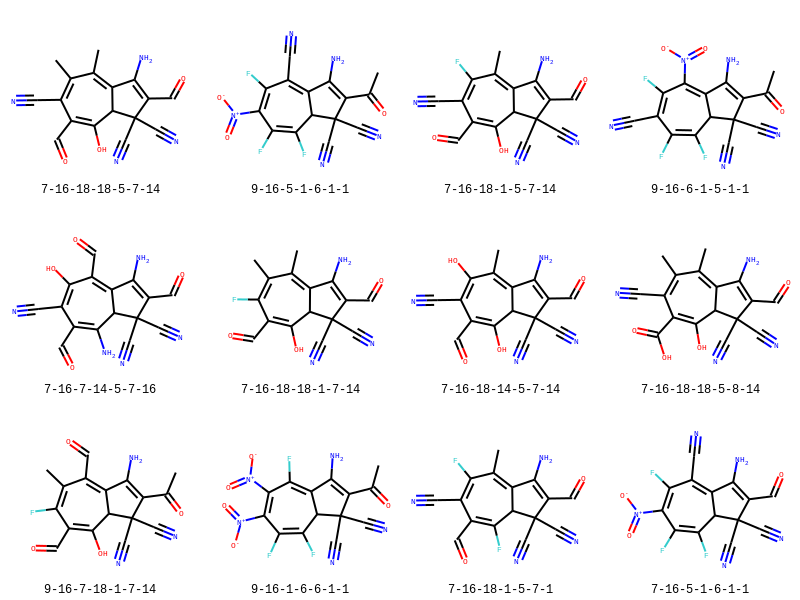

In [20]:
mols = []
genes = []
for row in df_ga_unique.itertuples():
    mols.append(get_mol(row.Index))
    genes.append(row.Index)

img = Draw.MolsToGridImage(mols,molsPerRow=4,legends=genes,subImgSize=(200,200))
img